# Ramsey-Cass-Koopmans model

Ramsey model from Chapter 2 of D. Romer's *Advanced Economics* looks as follows...

\begin{align}
    \dot{k}(t) =& k(t)^{\alpha} - c(t) - (g + n + \delta)k(t),\\
    \dot{c}(t) =& \Bigg[\frac{1}{\theta} \bigg[\alpha k(t)^{\alpha - 1} - \delta - \rho - \theta g\bigg]\Bigg]c(t)
\end{align}
...with boundary conditions...
\begin{align}
    k(0) =& k_0 \\
    lim_{t\rightarrow \infty} c(t) =& c^*
\end{align}

...where...

* Elasticity of output with respect to capital: $0 < \alpha < 1$
* Coefficient of relative risk aversion: $0 < \theta$
* Discount rate: $0 < \rho$
* Breakeven investment: $0 < g + n + \delta$
* Convergent lifetime utility: $0 < \rho - n - (1 - \theta)g$

Note that we are assuming two things...

1. Cobb-Douglas production
2. Constant Relative Risk Aversion (CRRA) preferences



In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sympy as sym

import pycollocation

In [3]:
# define some variables
A, K, L = sym.symbols("A, K, L")

In [4]:
# define some initial conditions
A0, L0 = sym.symbols("A0, L0")

# define some production parameters
alpha, delta = sym.symbols("alpha, delta")

# define growth rates
g, n = sym.symbols("g, n")

# define some preference parameters
theta, rho = sym.symbols("theta, rho")

In [5]:
# user defined extensive production function
def extensive_output(A, K, L, **params):
    """Output is a function of technology, A, capital, K, and labor, L."""
    alpha = params['alpha']
    return K**alpha * (A * L)**(1 - alpha)

def flow_utility(C, **params):
    """Flow utility from consumption (per capita)."""
    theta = params['theta']
    return (C**(1 - theta) - 1) / (1 - theta)

def steady_state_capital(A0, delta, g, K0, L0, n, rho, alpha, theta):
    """
    Equilibrium value of capital (per unit effective labor) with
    Cobb-Douglas production and Constant Relative Risk Aversion (CRRA)
    preferences.
    
    """
    return (alpha / (delta + rho + theta * g))**(1 / (1 - alpha))


In [54]:
class RamseyModelLike(object):
    
    def __init__(self, F, u, params):
        self.extensive_output = F
        self.flow_utility = u
        self.params = params
            
    @property
    def _change_of_variables(self):
        """Substitutions for C and r."""
        return {'C': self._per_capita_consumption, 'r': self.real_interest_rate}
        
    @property
    def _growth_rate_c(self):
        """Growth rate of consumption (per unit effective labor)."""
        return self._growth_rate_C - self._symbolic_params['g']
        
    @property
    def _growth_rate_C(self):
        """Growth rate of consumption (per person)."""
        return self.consumption_euler_equation.subs(self._change_of_variables)
    
    @property
    def _initial_condition_capital(self):
        """Intitial condition for capital stock (per unit effective labor)."""
        return self.params['K0'] / (self.params['A0'] * self.params['L0'])
        
    @property
    def _per_capita_consumption(self):
        """Symbolic expression for per capita consumption."""
        t, c = self._symbolic_vars[0::2]
        A0, g = self._symbolic_params['A0'], self._symbolic_params['g']
        return A0 * sym.exp(g * t) * c
        
    @property
    def _symbolic_params(self):
        """Return a dictionary of symbolic parameters."""
        return {key: sym.symbols(key) for key in self.params.iterkeys()}
    
    @property
    def _symbolic_vars(self):
        """Return a list of symbolic variables."""
        return sym.symbols(['t', 'k', 'c'])
    
    @property
    def boundary_conditions(self):
        """Boundary conditions for the model."""
        k0 = self._initial_condition_capital
        c_star = self.steady_state_consumption(**self.params)
        bcs = {'lower': [self._symbolic_vars[1] - k0],
               'upper': [self._symbolic_vars[2] - c_star]}
        return bcs
    
    @property
    def c_dot(self):
        """Symbolic expression defining the equation of motion for consumption (per unit effective labor)."""
        return self._growth_rate_c * self._symbolic_vars[2]
    
    @property
    def consumption_euler_equation(self):
        """
        Representative household's consumption Euler equation.

        The Euler equation implies that the growth rate of per
        capita consumption is proportional to the difference
        between the real interest rate and the discount rate of
        the representative household.

        """
        epsilon = self.elasticity_intertemporal_substitution
        r = self.real_interest_rate
        consumption_growth = epsilon * (r - self._symbolic_params['rho'])
        return consumption_growth
    
    @property
    def elasticity_intertemporal_substitution(self):
        """
        Elasticity of intertemporal substitution is reciprical of the
        coefficient of relative risk aversion.

        """
        return 1 / self.relative_risk_aversion_coef

    @property
    def k_dot(self):
        """Symbolic expression defining the equation of motion for capital stock (per unit effective labor)."""
        return self.equation_motion_capital(*self._symbolic_vars, **self._symbolic_params)
    
    @property
    def real_interest_rate(self):
        """Return the real interest rate (net depreciation)."""
        Y = self.extensive_output(1, self._symbolic_vars[1], 1,
                                  **self._symbolic_params)
        mpk = self.marginal_product_capital(Y, self._symbolic_vars[1])
        return mpk - self._symbolic_params['delta']
        
    @property
    def relative_risk_aversion_coef(self):
        """Return the coefficient of relative risk aversion."""
        C = sym.symbols("C")
        u = self.flow_utility(C, **self._symbolic_params)
        crra = -((C * sym.diff(u, C, 2)) / sym.diff(u, C, 1))
        return crra
    
    @property
    def rhs(self):
        """Symbolic expressions for the RHS of the system of ODE."""
        return {'k': self.k_dot, 'c': self.c_dot}
    
    @staticmethod
    def marginal_product_capital(Y, K):
        """Marginal product of capital."""
        return sym.diff(Y, K, 1)

    @staticmethod
    def marginal_product_labor(Y, L):
        """Marginal product of labor."""
        return sym.diff(Y, L, 1)
    
    @staticmethod
    def break_even_investment(k, delta, g, n, **params):
        """
        Return level of investment (per unit effective labor) required
        to maintain current level of capital (per unit effective labor).

        """
        return (g + n + delta) * k

    def intensive_output(self, k, **params):
        """
        Intensive output is a function of capital (per unit effective labor)
        and model parameters.

        """
        return self.extensive_output(1, k, 1, **params) 
    
    def actual_investment(self, k, c, **params):
        """Return investment (per unit effective labor)."""
        return self.intensive_output(k, **params) - c

    def equation_motion_capital(self, t, k, c, A0, delta, g, n, rho, **params):
        """Equation of motion for capital (per unit effective labor)."""
        k_dot = (self.actual_investment(k, c, **params) -
                 self.break_even_investment(k, delta, g, n, **params))
        return k_dot
        
    def steady_state_capital_locus(self, k, delta, g, n, **params):
        """
        Locus of points (k, c) such that :math:`\dot{k}=0`.

        Function returns the level of consumption (per unit
        effective labor) required in order to maintain a given
        level of capital (per unit effective labor).

        """
        locus = (self.intensive_output(k, **params) -
                 self.break_even_investment(k, delta, g, n, **params))
        return locus

    def steady_state_consumption(self, A0, delta, g, K0, L0, n, rho, **params):
        """Equilibrium value for consumption (per unit effective labor)."""
        k_star = steady_state_capital(A0, delta, g, K0, L0, n, rho, **params)
        c_star = self.steady_state_capital_locus(k_star, delta, g, n, **params)
        return c_star
            

In [55]:
# finally we need to define some parameters...
params = {'A0': 1.0, 'K0': 1.0, 'L0': 1.0, 'alpha': 0.33, 'delta': 0.04, 'theta': 1.05, 'rho': 0.05,
          'g': 0.02, 'n': 0.02}

model = RamseyModelLike(extensive_output, flow_utility, params)

In [56]:
model.elasticity_intertemporal_substitution

C**(-theta + 1)*C**(theta - 1)/theta

In [57]:
# create a dictionary representing the RHS of our model
print model._change_of_variables

{'C': A0*c*exp(g*t), 'r': alpha*k**alpha/k - delta}


In [58]:
model.real_interest_rate

alpha*k**alpha/k - delta

In [59]:
model.consumption_euler_equation.simplify()

(alpha*k**alpha - k*(delta + rho))/(k*theta)

In [60]:
model.boundary_conditions

{'lower': [k - 1.0], 'upper': [c - 1.30350166118058]}

...next we do the same for consumption...

\begin{align}
    0 =& k^{*\alpha} - c^* - (g + n + \delta)k^* \\
    c^* =& k^{*\alpha} - (g + n + \delta)k^*
\end{align}

In [61]:
# call function with numeric inputs and get a numeric result!
model.steady_state_consumption(**params)

1.303501661180578

## Using pyCollocation

In [62]:
bvp = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['k', 'c'],
                                                 independent_var='t',
                                                 rhs=model.rhs,
                                                 boundary_conditions=model.boundary_conditions,
                                                 params=model.params)

In [63]:
solver = pycollocation.OrthogonalPolynomialSolver(bvp)

In [64]:
# now this works for numerical values as well!
steady_state_capital(**params)

5.084580947867504

In [65]:
# define our domain of approximation
k0 = model._initial_condition_capital
domain = [0.0, 100.0]

# initial guess for capital
N = 1000
ts = np.linspace(domain[0], domain[1], N)
ks = steady_state_capital(**params) - (steady_state_capital(**params) - k0) * np.exp(-ts)
cs = np.log(ks)

def initial_polynomial(ts, xs, deg, domain):
    """Eventually need some to link to underlying basis functions!"""
    return np.polynomial.Chebyshev.fit(ts, ks, deg, domain)

def initial_coefs(ts, ks, cs, deg, domain):
    """Return dictionary of coefs."""
    capital = initial_polynomial(ts, ks, deg, domain)
    consumption = initial_polynomial(ts, cs, deg, domain)
    coefs = {'k': capital.coef, 'c': consumption.coef}
    return coefs

In [66]:
coefs_guess = initial_coefs(ts, ks, cs, 35, domain) 
solver.solve(kind="Chebyshev",
             coefs_dict=coefs_guess,
             domain=domain)

In [67]:
solver.result.x

array([  4.37225405e+00,   1.29407760e+00,  -9.72862387e-01,
         6.08921292e-01,  -3.18201558e-01,   1.37285311e-01,
        -4.62850602e-02,   9.22882156e-03,   2.25265028e-03,
        -4.07400457e-03,   3.21212000e-03,  -2.07493833e-03,
         1.24105453e-03,  -7.22117266e-04,   4.18592261e-04,
        -2.44435831e-04,   1.44396564e-04,  -8.63551432e-05,
         5.22449115e-05,  -3.19390960e-05,   1.97071578e-05,
        -1.22605018e-05,   7.68428915e-06,  -4.84844391e-06,
         3.07792569e-06,  -1.96514557e-06,   1.26163055e-06,
        -8.14606070e-07,   5.29424466e-07,  -3.47071441e-07,
         2.30580740e-07,  -1.56776432e-07,   1.10978890e-07,
        -8.39515496e-08,   4.59631210e-08,  -9.06485053e-09,
         1.17873943e+00,   2.28498625e-01,  -1.76366595e-01,
         1.16303877e-01,  -6.68076608e-02,   3.42707361e-02,
        -1.62089828e-02,   7.36702585e-03,  -3.37782840e-03,
         1.63268450e-03,  -8.50106911e-04,   4.74261609e-04,
        -2.78167064e-04,

In [68]:
# now create a visualizer for plot the solution...
visualizer = pycollocation.Visualizer(solver)

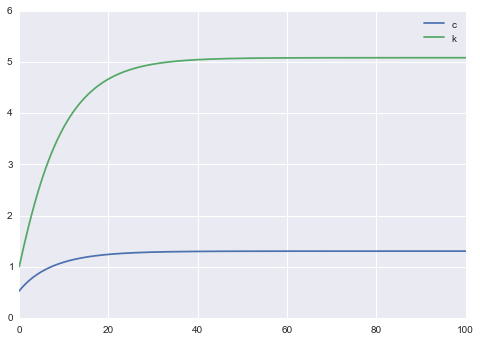

In [69]:
# plot the solution
visualizer.interpolation_knots = np.linspace(domain[0], domain[1], N)
visualizer.solution.plot()
plt.show()

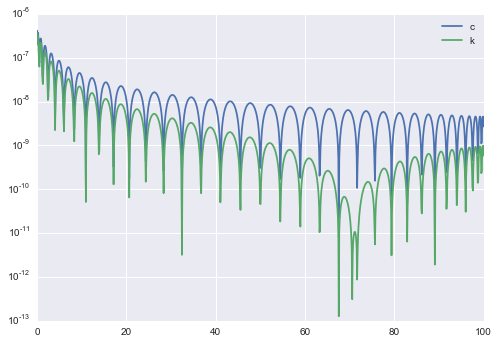

In [70]:
# plot the normalized residuals (they should be small everywhere!)
visualizer.normalized_residuals.plot(logy=True)
plt.show()